In [ ]:
import pandas as pd 
path = "/Users/anastasiiadobson/Library/CloudStorage/Dropbox/WORK/BOOTCAMP/SMOOTHIES/data/processed/tiktok_posts.csv"
df = pd.read_csv(path)


In [4]:
print(df.columns)

Index(['authorMeta.avatar', 'authorMeta.name', 'text', 'diggCount',
       'shareCount', 'playCount', 'commentCount', 'collectCount',
       'videoMeta.duration', 'musicMeta.musicName', 'musicMeta.musicAuthor',
       'musicMeta.musicOriginal', 'createTimeISO', 'webVideoUrl'],
      dtype='object')


In [ ]:
# Step 1: Imports
import pandas as pd
from pathlib import Path
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
df_tiktok = df.copy()
# Step 2: Download sentiment model
nltk.download("vader_lexicon")
sid = SentimentIntensityAnalyzer()

# Step 4: Preprocess TikTok data
df_tiktok["keyword"] = "TikTok"
df_tiktok["source"] = "TikTok"

# Use 'text' column directly
df_tiktok["sentiment_score"] = df_tiktok["text"].fillna("").apply(lambda x: sid.polarity_scores(x)["compound"])
df_tiktok["sentiment"] = pd.cut(
    df_tiktok["sentiment_score"],
    bins=[-1, -0.05, 0.05, 1],
    labels=["Negative", "Neutral", "Positive"]
)

# Format dates
df_tiktok["created_date"] = pd.to_datetime(df_tiktok["createTimeISO"], errors="coerce")
df_tiktok = df_tiktok.dropna(subset=["created_date"])
df_tiktok["month"] = df_tiktok["created_date"].dt.to_period("M").dt.to_timestamp()

# Optional: Preview
print(df_tiktok[["text", "sentiment", "sentiment_score", "month"]].head())

# Optional: Save
df_tiktok.to_csv("tiktok_sentiment.csv", index=False)

                                                text sentiment  \
0                        Day 2 of my smoothie detox    Neutral   
1  Mango Banana Smoothie 🥭🍌 #asmr #smoothie #reci...   Neutral   
2  🤩🔥 FLAT STOMACH WITH TROPICAL SMOOTHIE\n\n👉 Ty...  Positive   
3  Healthy smoothie 🫐🍌🍓#smoothie #fyp #viral #rec...  Positive   
4  high protein strawberry smoothie 🍓\n\n350cals ...  Positive   

   sentiment_score      month  
0           0.0000 2025-06-01  
1           0.0000 2025-08-01  
2           0.6124 2025-04-01  
3           0.4019 2025-04-01  
4           0.3612 2024-06-01  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anastasiiadobson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/sf/3_6zfybs6_xcm9ncfcfxk_zr0000gn/T/ipykernel_78849/1580927957.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_tiktok["month"] = df_tiktok["created_date"].dt.to_period("M").dt.to_timestamp()


In [12]:
print(df_tiktok.columns)

Index(['authorMeta.avatar', 'authorMeta.name', 'text', 'diggCount',
       'shareCount', 'playCount', 'commentCount', 'collectCount',
       'videoMeta.duration', 'musicMeta.musicName', 'musicMeta.musicAuthor',
       'musicMeta.musicOriginal', 'createTimeISO', 'webVideoUrl', 'keyword',
       'source', 'sentiment_score', 'sentiment', 'created_date', 'month'],
      dtype='object')


/var/folders/sf/3_6zfybs6_xcm9ncfcfxk_zr0000gn/T/ipykernel_78849/2534812019.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_tiktok["month"] = df_tiktok["created_date"].dt.to_period("M").dt.to_timestamp()


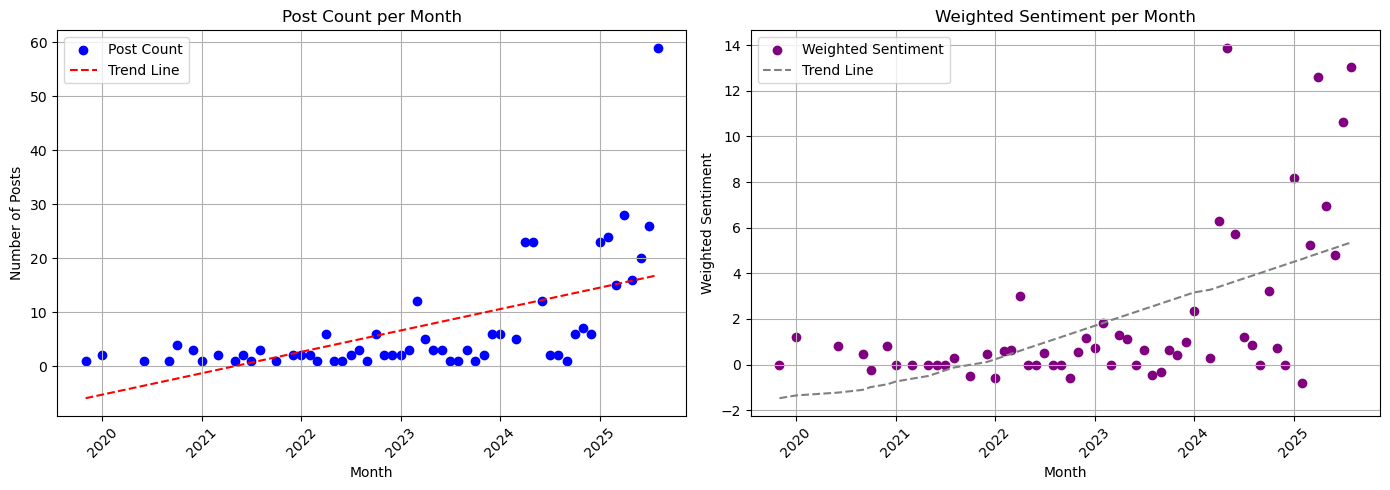

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Convert and clean date
df_tiktok["created_date"] = pd.to_datetime(df_tiktok["createTimeISO"], errors="coerce")
df_tiktok = df_tiktok.dropna(subset=["created_date"])
df_tiktok["month"] = df_tiktok["created_date"].dt.to_period("M").dt.to_timestamp()

# Step 2: Post count per month
monthly_counts = df_tiktok.groupby("month").size().reset_index(name="post_count")

# Regression for post count trend
x_post = monthly_counts["month"].map(pd.Timestamp.toordinal)
y_post = monthly_counts["post_count"]
slope_post, intercept_post = np.polyfit(x_post, y_post, 1)
trend_post = slope_post * x_post + intercept_post

# Step 3: Weighted sentiment per month
monthly_stats = (
    df_tiktok.groupby("month")
             .agg(
                 post_count=("sentiment_score", "count"),
                 avg_sentiment=("sentiment_score", "mean")
             )
             .reset_index()
)
monthly_stats["weighted_sentiment"] = monthly_stats["post_count"] * monthly_stats["avg_sentiment"]

# Regression for sentiment trend
x_sent = np.arange(len(monthly_stats))
y_sent = monthly_stats["weighted_sentiment"]
slope_sent, intercept_sent = np.polyfit(x_sent, y_sent, 1)
trend_sent = slope_sent * x_sent + intercept_sent

# Step 4: Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Left: Post Count
axs[0].scatter(monthly_counts["month"], y_post, color="blue", label="Post Count")
axs[0].plot(monthly_counts["month"], trend_post, color="red", linestyle="--", label="Trend Line")
axs[0].set_title("Post Count per Month")
axs[0].set_xlabel("Month")
axs[0].set_ylabel("Number of Posts")
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend()
axs[0].grid(True)

# Right: Weighted Sentiment
axs[1].scatter(monthly_stats["month"], y_sent, marker="o", color="purple", label="Weighted Sentiment")
axs[1].plot(monthly_stats["month"], trend_sent, linestyle="--", color="gray", label="Trend Line")
axs[1].set_title("Weighted Sentiment per Month")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Weighted Sentiment")
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

/var/folders/sf/3_6zfybs6_xcm9ncfcfxk_zr0000gn/T/ipykernel_78849/3158822672.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_tiktok["month"] = df_tiktok["created_date"].dt.to_period("M").dt.to_timestamp()


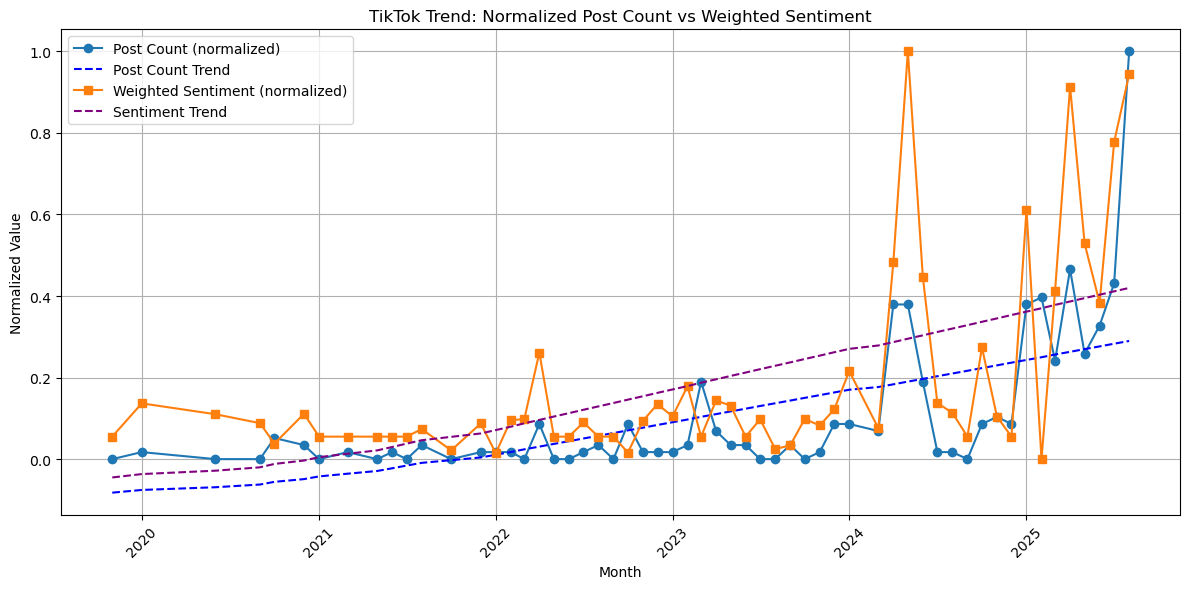

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Prepare the data
df_tiktok["created_date"] = pd.to_datetime(df_tiktok["createTimeISO"], errors="coerce")
df_tiktok = df_tiktok.dropna(subset=["created_date"])
df_tiktok["month"] = df_tiktok["created_date"].dt.to_period("M").dt.to_timestamp()

# Step 2: Monthly post count
monthly_counts = df_tiktok.groupby("month").size().reset_index(name="post_count")

# Step 3: Monthly weighted sentiment
monthly_stats = (
    df_tiktok.groupby("month")
             .agg(
                 post_count=("sentiment_score", "count"),
                 avg_sentiment=("sentiment_score", "mean")
             )
             .reset_index()
)
monthly_stats["weighted_sentiment"] = monthly_stats["post_count"] * monthly_stats["avg_sentiment"]

# Step 4: Align indexes and normalize for visualization
df_plot = pd.merge(monthly_counts, monthly_stats[["month", "weighted_sentiment"]], on="month", how="inner")
df_plot = df_plot.sort_values("month")

# Normalize both series to [0, 1] for visual comparison
df_plot["post_count_norm"] = (df_plot["post_count"] - df_plot["post_count"].min()) / (df_plot["post_count"].max() - df_plot["post_count"].min())
df_plot["weighted_sentiment_norm"] = (df_plot["weighted_sentiment"] - df_plot["weighted_sentiment"].min()) / (df_plot["weighted_sentiment"].max() - df_plot["weighted_sentiment"].min())

# Step 5: Fit trend lines
x = np.arange(len(df_plot))
post_trend = np.poly1d(np.polyfit(x, df_plot["post_count_norm"], 1))(x)
sentiment_trend = np.poly1d(np.polyfit(x, df_plot["weighted_sentiment_norm"], 1))(x)

# Step 6: Plot
plt.figure(figsize=(12, 6))
plt.plot(df_plot["month"], df_plot["post_count_norm"], label="Post Count (normalized)", marker="o")
plt.plot(df_plot["month"], post_trend, linestyle="--", color="blue", label="Post Count Trend")

plt.plot(df_plot["month"], df_plot["weighted_sentiment_norm"], label="Weighted Sentiment (normalized)", marker="s")
plt.plot(df_plot["month"], sentiment_trend, linestyle="--", color="purple", label="Sentiment Trend")

plt.title("TikTok Trend: Normalized Post Count vs Weighted Sentiment")
plt.xlabel("Month")
plt.ylabel("Normalized Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
import os
import re
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
import umap
import hdbscan
from bertopic import BERTopic

# ========== SETUP ==========
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

MAX_DOCS = 3000
EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
LANG = "english"
OUT_DIR = "outputs_topics"
os.makedirs(OUT_DIR, exist_ok=True)

# ========== 1. CLEAN TEXT ==========
df = df_tiktok.copy()
df["created_date"] = pd.to_datetime(df["createTimeISO"], errors="coerce")
df = df.dropna(subset=["created_date"])
df = df[(df["created_date"] >= "2023-01-01") & (df["created_date"] < "2025-07-01")].copy()

def basic_clean(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s\-']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text"] = df["text"].fillna("").map(basic_clean)
df = df.replace({"": np.nan}).dropna(subset=["text"])

# ========== 2. SAMPLE IF NEEDED ==========
if len(df) > MAX_DOCS:
    df = df.sample(MAX_DOCS, random_state=42).reset_index(drop=True)

docs = df["text"].tolist()

# ========== 3. BUILD MODELS ==========
def make_vectorizer(n_docs: int) -> CountVectorizer:
    min_df_abs = max(1, min(10, int(0.005 * max(n_docs, 1))))
    max_df_val = max(min_df_abs + 1, n_docs) if n_docs < 100 else 0.90
    print(f"min_df = {min_df_abs}, max_df = {max_df_val}, docs = {n_docs}")
    return CountVectorizer(
        stop_words=LANG,
        ngram_range=(1, 2),
        min_df=min_df_abs,
        max_df=max_df_val,
        max_features=20000
    )

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    low_memory=True,
    random_state=42
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=5,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

def build_topic_model(vectorizer_model: CountVectorizer, use_embeddings=True):
    return BERTopic(
        embedding_model=(EMBED_MODEL if use_embeddings else None),
        vectorizer_model=vectorizer_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        language=LANG,
        calculate_probabilities=False,
        verbose=True,
        nr_topics=None
    )

# ========== 4. RUN BERTopic ==========
vec = make_vectorizer(len(docs))

try:
    topic_model = build_topic_model(vec, use_embeddings=True)
    topics, _ = topic_model.fit_transform(docs)
except Exception as e:
    print(f"[BERTopic] Embedding failed: {e}. Retrying without embeddings…")
    topic_model = build_topic_model(vec, use_embeddings=False)
    topics, _ = topic_model.fit_transform(docs)

# ========== 5. ASSIGN + SAVE ==========
df["topic"] = topics

topic_info = topic_model.get_topic_info()
topic_info.to_csv(f"{OUT_DIR}/topics_tiktok.csv", index=False)

# Top words per topic
top_words = []
for tid in topic_info["Topic"]:
    if tid == -1:
        continue
    words = ", ".join([w for w, _ in topic_model.get_topic(tid)[:15]])
    top_words.append({"topic_id": tid, "top_words": words})

pd.DataFrame(top_words).to_csv(f"{OUT_DIR}/top_words.csv", index=False)

# Sample representative docs
rep_docs = []
for tid in topic_info["Topic"].head(10):
    if tid == -1:
        continue
    examples = topic_model.get_representative_docs(tid)[:5]
    rep_docs.append({"topic_id": tid, "sample_docs": examples})

print(f"\n✅ Done: {len(topic_info)-1 if -1 in topic_info.Topic.values else len(topic_info)} topics")

/Users/anastasiiadobson/miniconda3/envs/constructor/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-22 12:50:20,725 - BERTopic - Embedding - Transforming documents to embeddings.


min_df = 1, max_df = 0.9, docs = 261


Batches: 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]
2025-08-22 12:50:37,546 - BERTopic - Embedding - Completed ✓
2025-08-22 12:50:37,546 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-08-22 12:50:48,204 - BERTopic - Dimensionality - Completed ✓
2025-08-22 12:50:48,205 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-22 12:50:48,223 - BERTopic - Cluster - Completed ✓
2025-08-22 12:50:48,226 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-22 12:50:48,259 - BERTopic - Representation - Completed ✓



✅ Done: 9 topics


In [25]:
print(df_tiktok)

                                     authorMeta.avatar   authorMeta.name  \
0    https://p16-pu-sign-useast8.tiktokcdn-us.com/t...     jayythickness   
1    https://p16-common-sign-va.tiktokcdn-us.com/to...    lets_enjoyasmr   
2    https://p19-pu-sign-useast8.tiktokcdn-us.com/t...   smoothiedetox21   
3    https://p16-common-sign-va.tiktokcdn-us.com/to...        nadiatsvyk   
4    https://p16-common-sign-va.tiktokcdn-us.com/to...            ktrivz   
..                                                 ...               ...   
395  https://p16-sign.tiktokcdn-us.com/tos-useast5-...         thecoreyb   
396  https://p16-sign.tiktokcdn-us.com/tos-useast5-...   healthyish_mama   
397  https://p16-common-sign-va.tiktokcdn-us.com/to...  areadingrainbow1   
398  https://p16-pu-sign-useast8.tiktokcdn-us.com/t...        sipsbyeric   
399  https://p16-pu-sign-useast8.tiktokcdn-us.com/t...      thecincomedy   

                                                  text  diggCount  shareCount  \
0     

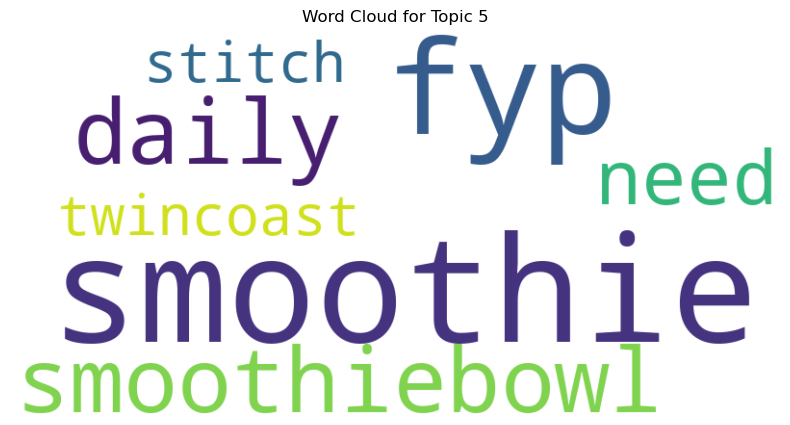

In [ ]:
#!pip install wordcloud
from wordcloud import WordCloud

# Select the topic to visualize
selected_topic = 5

# Extract keywords from 'Representation' column (it's a list)
words = topic_info.loc[topic_info["Topic"] == selected_topic, "Representation"].values[0]

# Flatten and join all words
wordcloud_text = " ".join(words)

# Generate and plot the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(wordcloud_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Word Cloud for Topic {selected_topic}")
plt.show()

In [20]:
# Optional: ensure both dataframes have lowercase text + keyword for better merge

df_bert = df.copy()
df_tiktok["text_clean"] = df_tiktok["text"].str.lower().str.strip()
df_tiktok["keyword"] = df_tiktok["keyword"].str.lower().str.strip()

df_bert["text_clean"] = df_bert["text"].str.lower().str.strip()
df_bert["keyword"] = df_bert["keyword"].str.lower().str.strip()

# Merge topic info from df_bert into df_tiktok
df_tiktok_with_topics = pd.merge(
    df_tiktok,
    df_bert[["text_clean", "keyword", "topic"]],
    on=["text_clean", "keyword"],
    how="left"
)

In [21]:
# Drop rows without topics
df_topic_sent = df_tiktok_with_topics.dropna(subset=["topic"]).copy()
df_topic_sent["topic"] = df_topic_sent["topic"].astype(int)

# Group: average sentiment by topic
df_topic_avg_sent = (
    df_topic_sent
    .groupby(["keyword", "topic"])["sentiment_score"]
    .mean()
    .reset_index()
    .rename(columns={"sentiment_score": "avg_sentiment"})
)

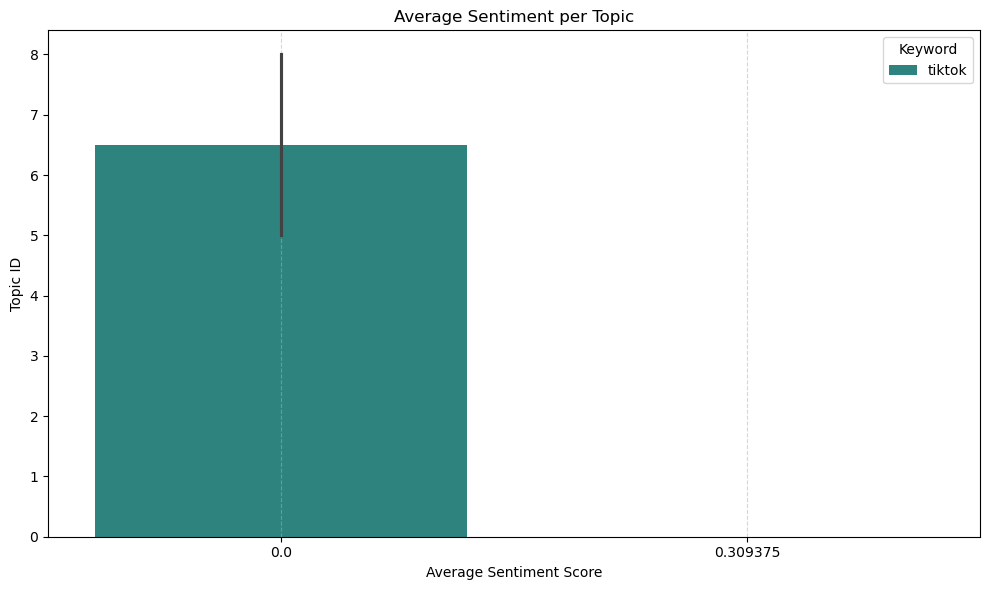

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by sentiment
df_topic_avg_sent = df_topic_avg_sent.sort_values("avg_sentiment")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_topic_avg_sent,
    y="topic",
    x="avg_sentiment",
    hue="keyword",
    dodge=True,
    palette="viridis"
)

plt.title("Average Sentiment per Topic")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Topic ID")
plt.legend(title="Keyword")
plt.grid(True, axis='x', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()